# Simulations for NJ4 single-strain model

In [63]:
from cobra.io import read_sbml_model

nj4 = read_sbml_model("GEMs/NJ4_curated.xml")

In [64]:
# make the reactions in the ABE pathway irreversible (included here because I cannot get this model behaviour to persist when using another function for some reason)

reactions = ["POR_syn",
            "ACACT1r",
            "HACD1",
            "ECOAH1",
            "ACOAD1fr",
            "ACOAD1",
            "BTCOARx",
            "PBUTT",
            "ADCi",
            "PTAr"]

reverse_reactions = ["ALCD4", "BUTKr", "BUTCT2", "ACKr", "ACACCT", "ACALD"]

for rx in reactions:
    nj4.reactions.get_by_id(rx).bounds = (0, 1000)

for rx in reverse_reactions:
    nj4.reactions.get_by_id(rx).bounds = (-1000, 0)

## static modelling

- see if it is possible to replicate the three observed chemostat stages of C. acetobutylicum

In [10]:
medium = list(nj4.medium.keys())
essential_rx = []

for rx in medium:
    with nj4:
        nj4.reactions.get_by_id(rx).lower_bound = 0
        sol = nj4.slim_optimize()
        if sol < 1e-6:
            essential_rx.append(rx)

print('essential metabolites:' ,[rx[3:] for rx in essential_rx])
print('essential reactions:' ,[rx for rx in essential_rx])

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


essential metabolites: ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe3_e', 'fol_e', 'k_e', 'mg2_e', 'mn2_e', 'pi_e', 'so4_e', 'ura_e', 'zn2_e']
essential reactions: ['EX_ca2_e', 'EX_cl_e', 'EX_cobalt2_e', 'EX_cu2_e', 'EX_fe3_e', 'EX_fol_e', 'EX_k_e', 'EX_mg2_e', 'EX_mn2_e', 'EX_pi_e', 'EX_so4_e', 'EX_ura_e', 'EX_zn2_e']


In [43]:
full_media = nj4.medium

medium = {rx:0.1 for rx in full_media.keys()}
medium['EX_xyl__D_e'] = 10
for rx in essential_rx:
    medium[rx] = 10

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


              pFBA sol  minimum    maximum
EX_ac_e       6.778916      0.0  11.288219
EX_but_e     -0.000000      0.0   9.863224
EX_etoh_e     3.726459      0.0  15.592007
EX_btoh_e     2.814485      0.0   7.796004
EX_acetone_e  0.000000      0.0   3.865117


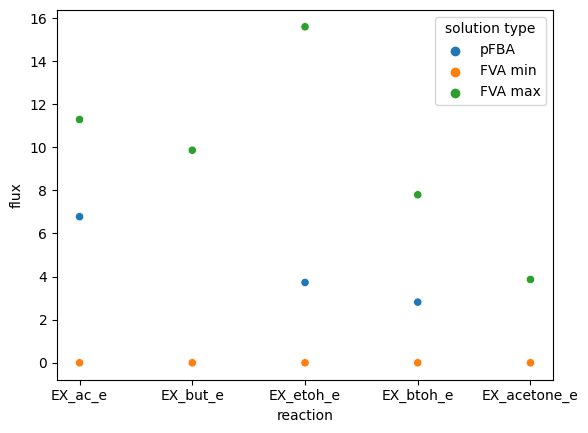

In [3]:
from utils import static_sim
sol_df = static_sim.get_productions(nj4, medium=static_sim.get_specific_medium(nj4, {"EX_xyl__D_e":10}))

print(sol_df)
static_sim.plot_production_stats(sol_df)

In [66]:
from cobra.flux_analysis import pfba

with nj4:
    acid_medium = static_sim.get_specific_medium(nj4, {"EX_xyl__D_e": 10, "EX_nh4_e": 10,}, fill_value=0.1)
    nj4.medium = acid_medium
    
    summary = nj4.summary()
    solution = nj4.optimize()
    pfba_solution = pfba(nj4)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [67]:
summary

Metabolite,Reaction,Flux,C-Number,C-Flux
arg__L_e,EX_arg__L_e,0.1,6,1.05%
asp__L_e,EX_asp__L_e,0.1,4,0.70%
ca2_e,EX_ca2_e,0.001847,0,0.00%
cl_e,EX_cl_e,0.001847,0,0.00%
cobalt2_e,EX_cobalt2_e,3.549E-05,0,0.00%
cu2_e,EX_cu2_e,0.0002516,0,0.00%
cys__L_e,EX_cys__L_e,0.03278,3,0.17%
fe2_e,EX_fe2_e,0.002383,0,0.00%
fe3_e,EX_fe3_e,0.002771,0,0.00%
fol_e,EX_fol_e,0.0002374,19,0.01%


- an amino acid conundrum, there are AAs present in the yeast-extract, but probably in really small amounts...
- is consuming xylose, however not as sole carbon-source due to AAs...
- is secreting ethanol, acetone, and butanol. which should be co-expressed in solventogenetic phase!

In [69]:
import escher
from escher import Builder

builder = Builder(map_json='escher_maps/ABE_pretty.json', model=nj4, height=600)

In [70]:
builder.reaction_data = pfba_solution.fluxes

In [71]:
builder

Builder(height=600, reaction_data={'12DGR120tipp': 0.0, '12DGR140tipp': 0.0, '12DGR160tipp': 0.0, '12DGR161tip…

In [13]:
def read_production_rates(sol):
    """Returns some metrics from a cobra solution in an easily readable format."""
    production_reactions = ["EX_but_e", "EX_ac_e", "EX_etoh_e", "EX_btoh_e", "EX_acetone_e"]
    print('Production fluxes:')
    print(sol.fluxes[production_reactions])

In [14]:
read_production_rates(solution)
read_production_rates(pfba_solution)

Production fluxes:
EX_but_e       -0.000000
EX_ac_e         7.451812
EX_etoh_e       8.504105
EX_btoh_e       0.916557
EX_acetone_e    0.000000
Name: fluxes, dtype: float64
Production fluxes:
EX_but_e       -0.000000
EX_ac_e         6.778916
EX_etoh_e       4.258709
EX_btoh_e       2.548359
EX_acetone_e    0.000000
Name: fluxes, dtype: float64


- model behaving as we would expect in solventogenic phase
- there are likely several optimal solutions here, should try to utilise FVA in some way to look into the solution space

In [15]:
static_sim.get_productions(nj4, medium=static_sim.get_specific_medium(nj4, {"EX_xyl__D_e":10}))

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


,pFBA sol,minimum,maximum
EX_ac_e,6.778916,0.0,11.288219
EX_but_e,-0.000000,0.0,9.863224
EX_etoh_e,4.258709,0.0,15.592007
EX_btoh_e,2.548359,0.0,7.796004
EX_acetone_e,0.000000,0.0,3.865117


- the model has the highest capability for ethanol production, and low capability for acid production
    - suggests and affinity for alcoholgenesis > solventogenesis > acidogenesis
- when increasing the possible H+ uptake rate, the possibility for solventogenesis increases!

Structured FVA result:

In [4]:
from utils import static_sim

medium = static_sim.get_specific_medium(nj4, {"EX_xyl__D_e": 10, "EX_nh4_e": 10,}, fill_value=0.1)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [72]:
ABE_REACTIONS = ["POR_syn", "ACACT1r", "HACD1", "ECOAH1", "ACOAD1fr", "ACOAD1", "BTCOARx", "PBUTT", "ADCi", 
                 "PTAr", "ALCD4", "BUTKr", "BUTCT2", "ACKr", "ACACCT", "ACALD", "ACtr", "FNRR", "ALCD2x",
                 "ETOHtrpp", "ETOHtex", "BTOHt", "ACEt", "BUTt"]

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


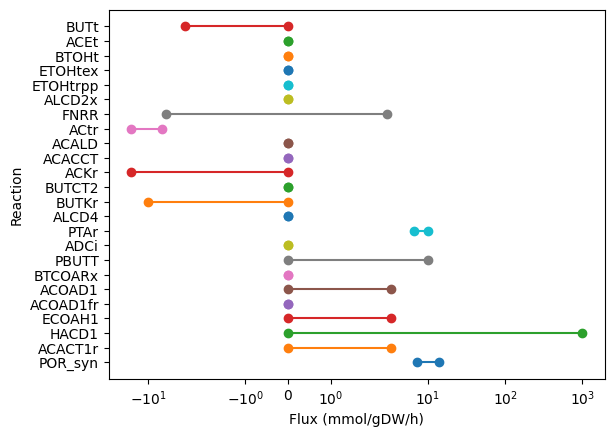

In [73]:
static_sim.plot_flux_ranges(model=nj4, medium=medium, reactions=ABE_REACTIONS)

In [62]:
nj4.metabolites.fdxrd_c

Metabolite identifier,fdxrd_c
Name,Reduced ferredoxin
Memory address,0x12508d450
Formula,Fe2S2
Compartment,C_c
In 4 reaction(s),"FNOR, CO2FO, POR_syn, FNRR"


In [61]:
nj4.reactions.FNRR

Reaction identifier,FNRR
Name,
Memory address,0x1261a2fb0
Stoichiometry,fdxrd_c + h_c + nad_c <=> fdxo_2_2_c + nadh_c Reduced ferredoxin + H+ + Nicotinamide adenine dinucleotide <=> Oxidized ferredoxin + Nicotinamide adenine dinucleotide - reduced
GPR,
Lower bound,-1000.0
Upper bound,1000.0


Use this analysis to restrict only a few reactions instead of all reactions!
BUTCT2 should def. be restricted. Restrict ACCACT then too since it is the same enzyme.

In [43]:
# make the reactions in the ABE pathway irreversible (included here because I cannot get this model behaviour to persist when using another function for some reason)

reactions = [
    # "POR_syn",
    #         "ACACT1r",
    #         "HACD1",
    #         "ECOAH1",
    #         "ACOAD1fr",
    #         "ACOAD1",
    #         "BTCOARx",
    #         "PBUTT",
    #         "ADCi",
    #         "PTAr"
            ]

reverse_reactions = [
                    #"ALCD4", "BUTKr", 
                     "BUTCT2", "ACACCT",
                     #"ACKr", "ACALD"
                     ]

for rx in reactions:
    nj4.reactions.get_by_id(rx).bounds = (0, 1000)

for rx in reverse_reactions:
    nj4.reactions.get_by_id(rx).bounds = (-1000, 0)

### Checking growth coupling

In [4]:
with nj4:
    nj4.medium = medium
    sol = nj4.optimize()

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [5]:
sol["EX_xyl__D_e"]

-10.0

In [6]:
sol.shadow_prices.to_frame().sort_values(by="shadow_prices", ascending=False)

,shadow_prices
pppg9_c,0.698996
appl_c,0.212640
ggptrc_c,0.205853
aact_c,0.205853
cpppg3_c,0.178708
...,...
murein5px4px4p_p,-1.000990
murein5p5p5p_p,-1.007776
mql8_c,-1.013431
mqn8_c,-1.020218


In [7]:
sol.to_frame().query("abs(fluxes) > 1e-6 and abs(reduced_costs) > 1e-6").sort_values(by="reduced_costs", ascending=False)

,fluxes,reduced_costs
EX_asp__L_e,-0.1,-0.013573
EX_ser__L_e,-0.1,-0.013573
EX_thr__L_e,-0.1,-0.029408
EX_xyl__D_e,-10.0,-0.042980
EX_glu__L_e,-0.1,-0.054291
EX_hxan_e,-0.1,-0.108582
EX_h_e,-0.1,-0.117630


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

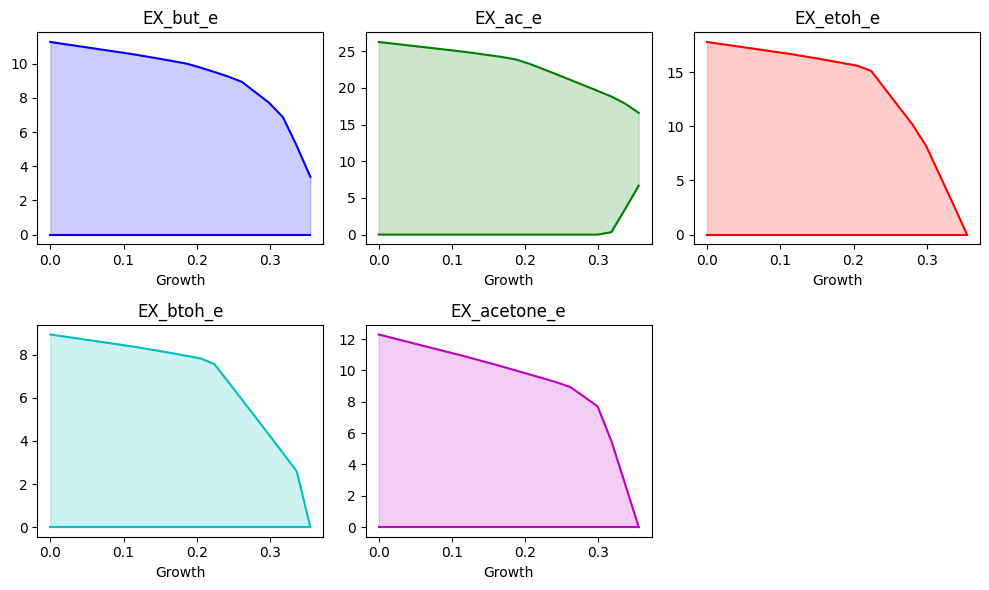

In [65]:
from utils import static_sim

medium = static_sim.get_specific_medium(nj4, {"EX_xyl__D_e": 10, "EX_nh4_e": 10,}, fill_value=0.1)

prod_reactions = ["EX_but_e", "EX_ac_e", "EX_etoh_e", "EX_btoh_e", "EX_acetone_e"]

static_sim.plot_flux_envelopes(nj4, medium=medium, reactions=prod_reactions)

In [14]:
from utils import static_sim

#medium = static_sim.get_specific_medium(nj4, {"EX_xyl__D_e": 10})

prod_reactions = ["EX_but_e", "EX_ac_e", "EX_etoh_e", "EX_btoh_e", "EX_acetone_e"]

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


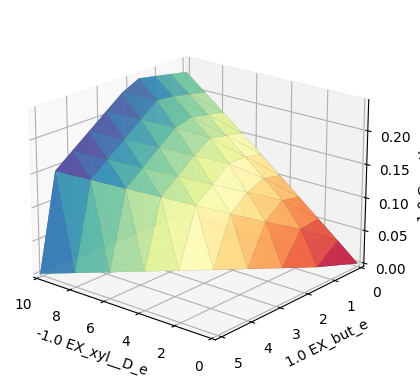

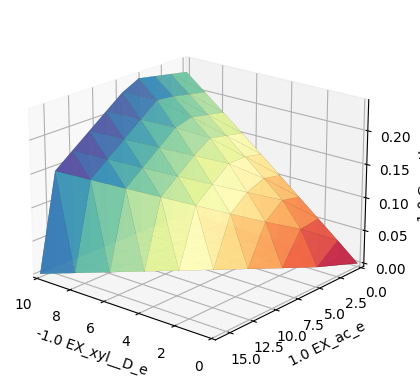

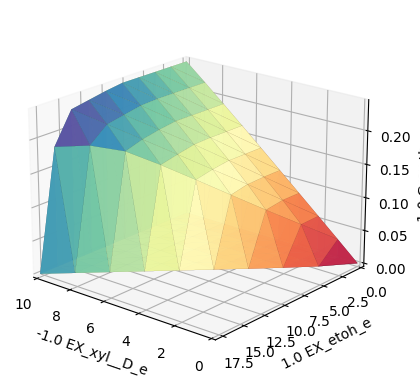

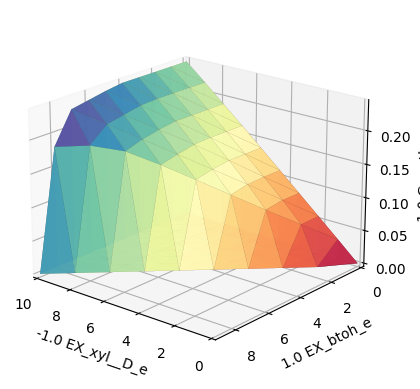

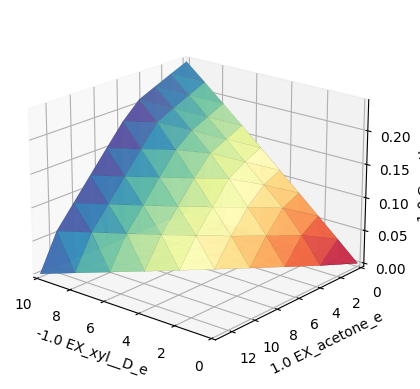

In [15]:
import straindesign as sd
import matplotlib.pyplot as plt

with nj4:
    nj4.medium = medium

    for rx in prod_reactions:
        _,_,plot = sd.plot_flux_space(nj4,('-EX_xyl__D_e',rx, 'Growth'),points=10, show=False);
        plot._axes.view_init(elev=20, azim=130)
        plt.show()

## More detailed acidogenic / solventogenic modelling

At standard growth maximisation the model should prefer butyrate / acetate production - since this is the strategy that Clostridium bacteria chose durting exponential growth phase.

Modelling og solventogenic phase as detailed in methods from: [Genome-scale reconstruction and in silico analysis of the Clostridium acetobutylicum ATCC 824 metabolic network](https://doi.org/10.1007/s00253-008-1654-4) (minimal metabolic adjustment from acidogenesis) and [Stoichiometric modeling of Clostridium acetobutylicum fermentations with non-linear constraints](https://doi.org/10.1016/S0168-1656(99)00022-X) (non-liner constraint on acetate and butyrate re-utilisation).

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


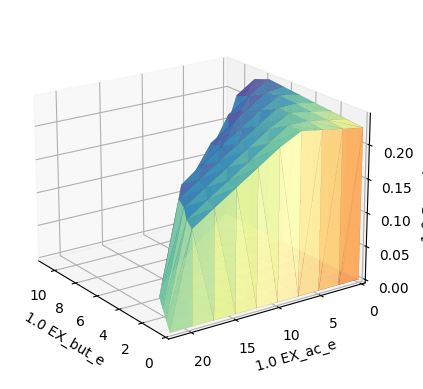

In [29]:
import straindesign as sd
import matplotlib.pyplot as plt
from utils import static_sim

medium = static_sim.get_specific_medium(nj4, {"EX_xyl__D_e": 10, "EX_nh4_e": 10,})

with nj4:
    nj4.medium = medium

    _,_,plot = sd.plot_flux_space(nj4,('EX_but_e','EX_ac_e', 'Growth'),points=10, show=False);
    plot._axes.view_init(elev=20, azim=145)
    plt.show()

- seems like model doesn't "want" to produce ABE-products simultaneously

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


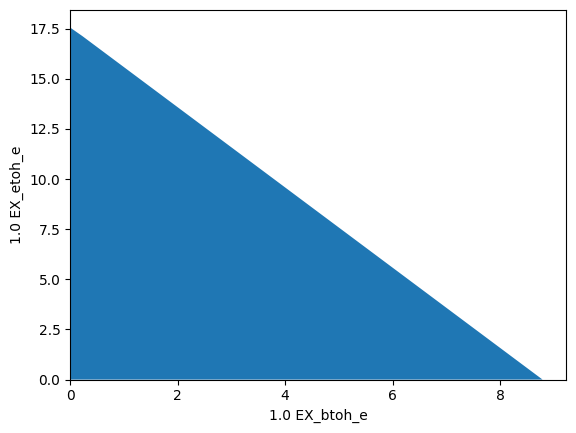

In [11]:
with nj4:
    nj4.medium = medium
    sd.plot_flux_space(nj4,('EX_btoh_e','EX_etoh_e'));

In [2]:
from utils import static_sim

acidogenic_medium = static_sim.get_specific_medium(nj4, {"EX_xyl__D_e": 10})

with nj4:
    nj4.medium = acidogenic_medium
    acidogenic_summary = nj4.summary()
    acidogenic_sol = nj4.optimize()

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


## solventogenic phase

impose constraints on butyrate and acetate uptake like in the article, then solve a MOMA problem from the previous solution like done in the iJL432 paper

use data from CBP paper to find appropriate ac / but constraint?

In [26]:
from utils.flux_coupling import add_ratio_constraint_cobra

add_ratio_constraint_cobra(nj4, "EX_but_e" , "EX_ac_e", 0.315)

Metabolite identifier,ratio_EX_but_e_EX_ac_e
Name,
Memory address,0x147649b10
Formula,None
Compartment,pseudo
In 2 reaction(s),"EX_ac_e, EX_but_e"


In [4]:
from cobra.flux_analysis import moma

solventogenic_medium = static_sim.get_specific_medium(nj4, {"EX_xyl__D_e": 10, "EX_but_e": 10, "EX_ac_e": 10, "EX_h_e": 10})

with nj4:
    nj4.medium = solventogenic_medium

    nj4.reactions.EX_but_e.bounds = (-10, -2)
    
    # solve a moma problem!
    solventogenic_sol = moma(nj4, solution=acidogenic_sol)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [5]:
import escher
from escher import Builder

builder_acido = Builder(map_json='ABE_pretty.json', model=nj4, height=600)
builder_acido.reaction_data = acidogenic_sol.fluxes
builder_acido

Builder(height=600, reaction_data={'12DGR120tipp': 0.0, '12DGR140tipp': 0.0, '12DGR160tipp': 0.0, '12DGR161tip…

In [6]:
import escher
from escher import Builder

builder_solvento = Builder(map_json='ABE_pretty.json', model=nj4, height=600)
builder_solvento.reaction_data = solventogenic_sol.fluxes
builder_solvento

Builder(height=600, reaction_data={'12DGR120tipp': 0.0, '12DGR140tipp': 0.0, '12DGR160tipp': 0.0, '12DGR161tip…

## dynamic modelling

In [1]:
from cobra.io import read_sbml_model

nj4 = read_sbml_model("GEMs/NJ4_curated.xml")

In [2]:
import pandas as pd

media_db = pd.read_csv("medium.tsv", sep="\t")

nj4_med = media_db[media_db["medium"] == "nj4_med"]

UNLIMITED_METABOLITES = ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e','h_e', 'k_e', 'h2o_e', 'mg2_e', 
                    'mn2_e', 'mobd_e', 'na1_e', 'nh4_e', 'ni2_e', 'pi_e', 'so4_e', 'zn2_e']

medium = [str(m+"_e") for m in nj4_med["compound"].tolist()]
added_metabilotes = set(medium) - set(UNLIMITED_METABOLITES)
added_metabilotes = {k:0.5 for k in added_metabilotes}
added_metabilotes["xyl__D_e"] = 20 # 20 mmol corresponds to 60 g/L xylose

In [53]:
from utils.comets_functions import single_strain

sim = single_strain(model=nj4, medium=added_metabilotes, sim_time=40)


Running COMETS simulation ...
Done!


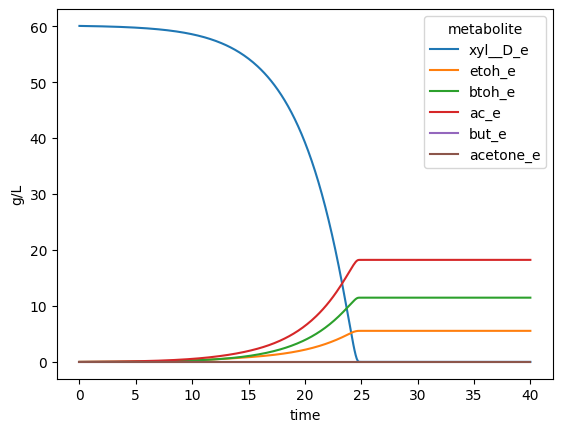

In [54]:
import seaborn as sns
from utils.comets_functions import plot_metabolites, plot_biomass, plot_reaction_flux

metabolites = ["xyl__D_e", "etoh_e", "but_e", "btoh_e", "ac_e", "acetone_e"]

plot_metabolites(sim, metabolites)

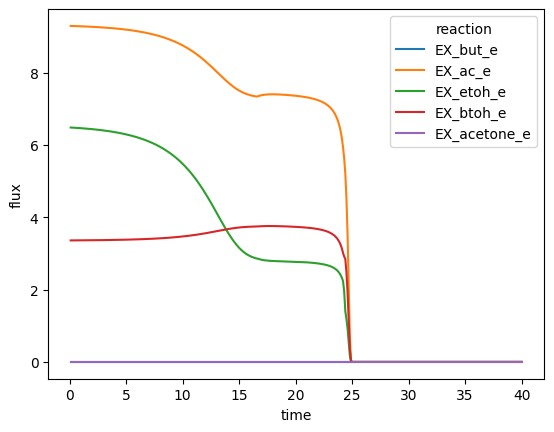

In [55]:
plot_reaction_flux(sim, prod_reactions, "NJ4")

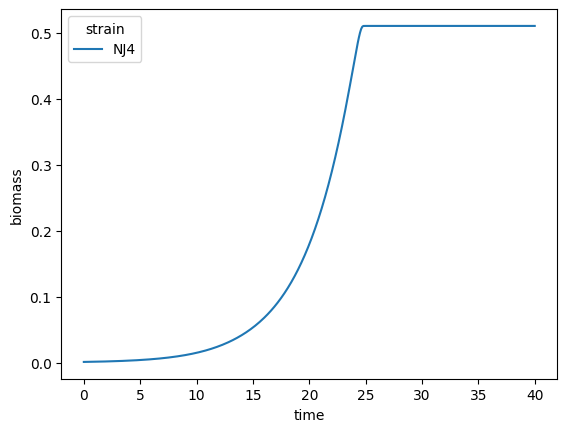

In [56]:
plot_biomass(sim)

In [57]:
import escher
from escher import Builder

animation = Builder(map_json='ABE_pretty.json', model=nj4, height=600)

In [59]:
from time import sleep
from tqdm.notebook import tqdm

fluxes = sim.get_species_exchange_fluxes("NJ4")
fluxes = sim.fluxes_by_species["NJ4"].drop(columns=["x", "y"])
melted_fluxes = fluxes.melt(id_vars="cycle", value_name="flux", var_name="reaction")

n_cycles = fluxes.shape[0]

for i in tqdm(range(n_cycles)):
    point_in_time = melted_fluxes[melted_fluxes["cycle"] == i]
    flux_series = point_in_time.set_index("reaction")["flux"]
    animation.reaction_data = flux_series
    sleep(0.1)

  0%|          | 0/400 [00:00<?, ?it/s]

In [58]:
animation

Builder(height=600)

In [3]:
vmax_dict = {"EX_xyl__D_e": 1}

In [4]:
from utils.comets_functions import single_strain

sim = single_strain(model=nj4, medium=added_metabilotes, sim_time=40, vmax_dict=vmax_dict)


Running COMETS simulation ...
Done!
